You can uncomment the Installation commands for need libraries

In [1]:
# pip install gym_super_mario_bros==7.3.0 nes_py

     -------------------------------------- 198.6/198.6 kB 1.7 MB/s eta 0:00:00
     ---------------------------------------- 77.7/77.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 696.4/696.4 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 14.7/14.7 MB 2.2 MB/s eta 0:00:00
     ---------------------------------------- 1.1/1.1 MB 1.4 MB/s eta 0:00:00
     ---------------------------------------- 78.4/78.4 kB 2.2 MB/s eta 0:00:00
  Using cached importlib_metadata-4.11.4-py3-none-any.whl (18 kB)
  Using cached zipp-3.8.

# 1. Setup Mario

In [1]:
# Import the game
import gym_super_mario_bros
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [2]:
SIMPLE_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [3]:
# Setup game
env = gym_super_mario_bros.make('SuperMarioBros2-v1')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [4]:
# Create a flag - restart or not
done = True
# Loop through each frame in the game
for step in range(5000):
    # Start the game to begin with
    if done:
        # Start the game
        state = env.reset()
    state, reward, done, info = env.step(env.action_space.sample())
    env.render()

env.close()

# 2. Preprocess Environment

Before installing pytorch you need to visit their official site and check which version of pytorch you need to install

Pytorch Site: https://pytorch.org/get-started/locally/

In [5]:
# pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

In [6]:
# pip install stable-baselines3[extra]

In [7]:
# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import Matplotlib, to show the impact of frame stacking
from matplotlib import pyplot as plt

d:\Machine Learning\Machine Learning Projects\Mario-ReinforceLearning\mario\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# 1. Create the base environment
env = gym_super_mario_bros.make('SuperMarioBros2-v1')
# 2. Simplify the controls
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# 3. Grayscale
env = GrayScaleObservation(env, keep_dim=True)
# 4. Wrap inside the dummy environment
env = DummyVecEnv([lambda: env])
# 5. Stack the frames
env = VecFrameStack(env, 4, channels_order='last')

In [9]:
state = env.reset()

In [10]:
state.shape

(1, 240, 256, 4)

In [11]:
state, reward, done, info = env.step([5])

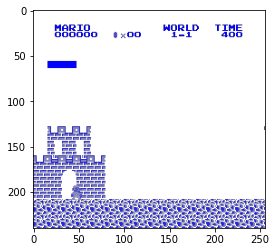

In [12]:
plt.imshow(state[0])

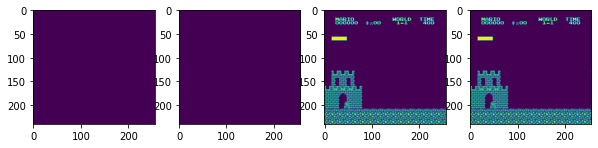

In [13]:
plt.figure(figsize=(10, 8))
for idx in range(state.shape[3]):
    plt.subplot(1, 4, idx+1)
    plt.imshow(state[0][:, :, idx])
plt.show()

# 3. Train the RL Model

In [14]:
# Import os for file path management
import os
# Import PPO for algorithms
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [15]:
class TrainAndLoggingCallback(BaseCallback):
    
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
        
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True


In [16]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [17]:
# Setup model callback, save every 10000 steps
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [18]:
# This is the AI model started
# You can change the learning rate for better performance
# but the smaller the value, the longer it takes to train the model
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001,
             n_steps=512)

Using cuda device
Wrapping the env in a VecTransposeImage.


In [19]:
# Tain the AI Model
# You can change the total_timesteps for better performance, 
# but the larger the value, the longer it takes to train the model
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/PPO_2


d:\Machine Learning\Machine Learning Projects\Mario-ReinforceLearning\mario\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


----------------------------
| time/              |     |
|    fps             | 94  |
|    iterations      | 1   |
|    time_elapsed    | 5   |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 79            |
|    iterations           | 2             |
|    time_elapsed         | 12            |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 2.8448412e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | -0.00888      |
|    learning_rate        | 1e-06         |
|    loss                 | 177           |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000179     |
|    value_loss           | 381           |
-------------------------------------------
-----

In [21]:
model.save('MarioTestModel')

In [47]:
# Load Model
model = PPO.load('./train/best_model_100000')

In [48]:
state = env.reset()

OSError: exception: access violation reading 0x000000000003C208

In [ ]:
state = env.reset()
while True:
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

KeyboardInterrupt: 

In [46]:
# To close the program, but after doing so you need to restart your kernal
env.close()